In [11]:
import torch 
import numpy as np
import time


def ui(x, y , model):
    return model(torch.cat((x.unsqueeze(-1), y.unsqueeze(-1)), dim=-1))

def f(x, y ,model):
    x.requires_grad_(True)
    y.requires_grad_(True)
    u = ui(x, y ,model)
   
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    u_y = torch.autograd.grad(u, y, torch.ones_like(u), create_graph=True, retain_graph=True)[0]
    
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True,retain_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, torch.ones_like(u_y), create_graph=True,retain_graph=True)[0]

    
    
    return u_xx + u_yy 




def f2(x, y ,model):
    
    f_pred = f(x, y ,model)
    r = (f_pred - tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) -tf.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2) )
    return torch.abs(r)
def adaptive_collocation_points(x, y, model, k=1.0):
   
    residuals = f2(x, y, model)
    
    p = residuals**k / torch.sum(residuals**k)
    indices = torch.multinomial(p.flatten(), num_samples=p.numel(), replacement=True)
    x_new = x.flatten()[indices].unsqueeze(1)
    y_new = y.flatten()[indices].unsqueeze(1)

 
    return x_new, y_new
#initial and boundary conditions losses
def loss_boundary_1(x , model):
    u_pred = ui(x, -torch.ones_like(x),model)
    u_boundary =  100*torch.exp(-10*(x**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    
    
    

    return torch.mean((u_pred - u_boundary)**2)
def loss_boundary_2(x,model):

    
    
    u_pred = ui(x, torch.ones_like(x),model)
    u_boundary =  100*torch.exp(-10*(x**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)

def loss_boundary_3(y,model):
    u_pred = ui(torch.ones_like(y),y,model)
    u_boundary =  100*torch.exp(-10*(y**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)

def loss_boundary_4(y ,model):
    u_pred = ui(-torch.ones_like(y),y,model)
    u_boundary =  100*torch.exp(-10*(y**2+1))
    u_boundary = u_boundary.unsqueeze(0).unsqueeze(-1)
    
    

    return torch.mean((u_pred - u_boundary)**2)
def check_for_interrupt():
    try:
        time.sleep(0)
    except KeyboardInterrupt:
        print("Interrupted!")
        raise KeyboardInterrupt

# pde loss

def loss_fn(x, y ,model ):

    f_pred = f(x, y ,model)

    f_exact = torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) +torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
    
    
    return torch.mean((f_pred-f_exact)**2) 

def create_grid(num_points):
    x = np.linspace(-1, 1, num_points)
    y = np.linspace(-1, 1, num_points)
    x_grid, y_grid = np.meshgrid(x, y)
    x_grid = x_grid.flatten()
    y_grid = y_grid.flatten()
    return x_grid, y_grid

# Step 2: Randomly select points from the grid
def select_random_points(x_grid, y_grid, num_samples):
    indices = np.random.choice(len(x_grid), num_samples, replace=False)
    selected_x = x_grid[indices]
    selected_y = y_grid[indices]
    return selected_x, selected_y




In [13]:
import torch
import torch.nn as nn

class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1
        self.modes2 = modes2

        self.scale = 1 / (in_channels * out_channels)
        self.weights1 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.randn(in_channels, out_channels, modes1, modes2, dtype=torch.cfloat))

    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x, y), (in_channel, out_channel, x, y) -> (batch, out_channel, x, y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coefficients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=(-2, -1))

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize , self.out_channels, x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-2), x.size(-1)))
        return x
    
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2, width):
        super(FNO2d, self).__init__()

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9

        self.fc0 = nn.Sequential(*[nn.Linear(2, self.width)])  

        self.conv0 = nn.Sequential(*[SpectralConv2d(self.width, self.width, self.modes1, self.modes2)])
        self.conv1 = nn.Sequential(*[SpectralConv2d(self.width, self.width, self.modes1, self.modes2)])
        self.conv2 = nn.Sequential(*[SpectralConv2d(self.width, self.width, self.modes1, self.modes2)])
        self.conv3 = nn.Sequential(*[SpectralConv2d(self.width, self.width, self.modes1, self.modes2)])
        
        self.w0 = nn.Sequential(*[nn.Conv2d(self.width, self.width, 1)])
        self.w1 = nn.Sequential(*[nn.Conv2d(self.width, self.width, 1)])
        self.w2 = nn.Sequential(*[nn.Conv2d(self.width, self.width, 1)])
        self.w3 = nn.Sequential(*[nn.Conv2d(self.width, self.width, 1)])

        self.fc1 = nn.Sequential(*[nn.Linear(self.width, 128)])
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        
        x = self.fc0(x)
        x = x.permute(2, 0, 1).unsqueeze(0)
        
        x = self.conv0(x) + self.w0(x)
        x = torch.tanh(x)
        x = self.conv1(x) + self.w1(x)
        x = torch.tanh(x)
        x = self.conv2(x) + self.w2(x)
        x = torch.tanh(x)
        x = self.conv3(x) + self.w3(x)
        x = torch.tanh(x)

        x = x.permute(0, 2, 3, 1)
        
        x = self.fc1(x)
        x = torch.tanh(x)
        x = self.fc2(x)
        return x

def loss_fn(x, y ,model ):

    f_pred = f(x, y ,model)

    f_exact = torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*x**2) +torch.exp(-10 * (x**2 + y**2))*(-20)*(1-20*y**2)
   
    
    return torch.mean((f_pred-f_exact)**2) 
model_2 = FNO2d(20, 20, 15)

x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)


optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

for epoch in range(100):
    optimizer.zero_grad()
    
    loss = loss_fn(x, y, model_2) + (loss_boundary_2(x,model_2) + loss_boundary_3(y,model_2)) + (loss_boundary_4(y,model_2) + loss_boundary_1(x,model_2))
    u_pred = ui(x, y, model_2)
    mse = torch.mean((u_pred.reshape(100,100)- torch.exp(-10 * (x**2 + y**2)))**2 )
    loss.backward(retain_graph=True)
    optimizer.step()
    scheduler.step()
    print(f'Epoch {epoch}, Loss: {loss.item()} ,mse: {mse.item()}')
      



Epoch 0, Loss: 30.97104835510254 ,mse: 0.11560926586389542
Epoch 1, Loss: 30.8945369720459 ,mse: 0.08865367621183395
Epoch 2, Loss: 30.838973999023438 ,mse: 0.06729873269796371
Epoch 3, Loss: 30.80309295654297 ,mse: 0.0513543039560318
Epoch 4, Loss: 30.784738540649414 ,mse: 0.040464695543050766
Epoch 5, Loss: 30.78034782409668 ,mse: 0.03400888666510582
Epoch 6, Loss: 30.784555435180664 ,mse: 0.03100704401731491
Epoch 7, Loss: 30.79075813293457 ,mse: 0.030140554532408714
Epoch 8, Loss: 30.793376922607422 ,mse: 0.03013043850660324
Epoch 9, Loss: 30.78974151611328 ,mse: 0.030192865058779716
Epoch 10, Loss: 30.77972412109375 ,mse: 0.03009517304599285
Epoch 11, Loss: 30.764455795288086 ,mse: 0.02993745356798172
Epoch 12, Loss: 30.745182037353516 ,mse: 0.029929039999842644
Epoch 13, Loss: 30.722576141357422 ,mse: 0.03025173954665661
Epoch 14, Loss: 30.696386337280273 ,mse: 0.03099803999066353
Epoch 15, Loss: 30.665300369262695 ,mse: 0.03216221183538437
Epoch 16, Loss: 30.626893997192383 ,mse

torch.Size([1, 100, 100, 1])


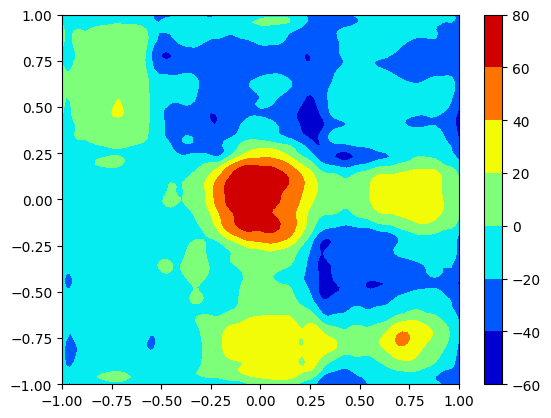

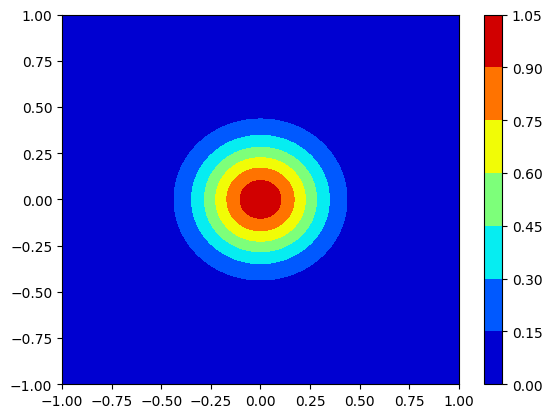

In [14]:
import matplotlib.pyplot as plt
x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)
u_exact = torch.exp(-10 * (x**2 + y**2))
u= ui(x, y ,model_2)
print(u_pred.shape)
plt.contourf(x,y,100*u_pred.detach().numpy().reshape(100,100),cmap='jet')
plt.colorbar()
plt.show()


plt.contourf(x,y,u_exact,cmap='jet')
plt.colorbar()
plt.show()

In [8]:
device = torch.device('cuda')

print('Using device:', device)

Using device: cuda


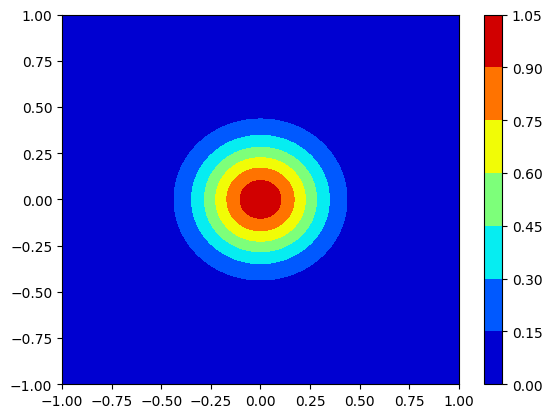

In [48]:
import numpy as np
import matplotlib.pyplot as plt

x = torch.linspace(-1, 1, 100)
y = torch.linspace(-1, 1, 100)
x, y = torch.meshgrid(x, y)
u_ex = torch.exp(-10 * (x**2 + y**2))

plt.contourf(x, y, u_ex , cmap='jet')
plt.colorbar()
plt.show()